In [ ]:
!pip install -qq google-play-scraper

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.4 MB/s 


In [ ]:
# libraries
from google_play_scraper import Sort, reviews
import pandas as pd
import re
import string
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# **Pengambilan Data**

In [ ]:
result, continuation_token = reviews(
    'com.telkom.tracencare',
    lang='id', # bahasa indonesia
    country='id',
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    count=23000, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
)

result, _ = reviews(
    'com.telkom.tracencare',
    continuation_token=continuation_token # defaults to None(load from the beginning)
)

In [ ]:
new_my_dict = result
df = pd.DataFrame.from_dict(new_my_dict) 
df_reviews = df[["content", "score", "at", "reviewCreatedVersion"]]
df_reviews.to_csv('review_content_raw_to_predict.csv', index=False)

# **Pelabelan Data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Skripsi_Pelabelan - label_raw2.csv', delimiter=',')
df = df[['content', 'label']]

In [ ]:
df.head()

,content,label
0,keren,pos
1,Membantu,pos
2,Bagus,pos
3,Ngerespon di wa lama banget,neg
4,manfaat sekali,pos


In [ ]:
df['label'].value_counts()

pos    3505
neg    1679
Name: label, dtype: int64

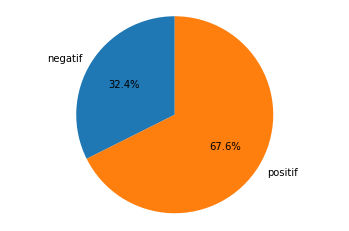

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'negatif', 'positif'
sizes = [df['label'].value_counts().neg, df['label'].value_counts().pos]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# **Pra-Proses Data**

In [ ]:
class DataCleaning:
  # Initialization
  factory     = StemmerFactory()
  stemmer     = factory.create_stemmer()
  kamus_alay1 = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/Kamus-Alay/main/Kamu-Alay.csv')
  kamus_alay1 = kamus_alay1.set_index('kataAlay')
  kamus_alay2 = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
  kamus_alay2 = kamus_alay2.filter(['slang', 'formal'], axis=1)
  kamus_alay2 = kamus_alay2.drop_duplicates(subset=['slang'], keep='first')
  kamus_alay2 = kamus_alay2.set_index('slang')
  stopword1   = list(pd.read_csv('https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt', header = None)[0])
  custom_word = []

  @classmethod
  def CleanDataFrame(cls, df, col_name, jum_minimum=None, minimum_kata=0):

    final_list_clean = []
    final_list_kotor = []
    ##
    label = []
    if jum_minimum == None: jum_minimum = len(df)
    if len(df) < jum_minimum: raise "Jumlah Data Yang Diinginkan melebihi Data yang Ada"
    i = 0
    current = 0
    
    while i < len(df):
      current_kalimat = df.loc[i][col_name]
      ##
      label_kalimat = df.loc[i]['label']
      clean_kalimat = cls.__cleanSentence__(current_kalimat)
      if (len(clean_kalimat.split(' ')) > minimum_kata):
        if (clean_kalimat):
          final_list_clean.append(clean_kalimat)
          final_list_kotor.append(current_kalimat)        
          ##
          label.append(label_kalimat)
          current += 1
          if current % 10 == 0:
            print("Memproses {} data".format(current))

      if current == jum_minimum:
        break
      i += 1
    
    data = {
        'raw': final_list_kotor,
        'processed': final_list_clean,
        ##
        'label': label
    }

    return pd.DataFrame(data)

  @classmethod
  def CleanSentence(cls, text):
    return cls.__cleanSentence__(text)

  @classmethod
  def __cleanSentence__(cls, text):
    '''
    Melakukan prapemrosesan pada suatu kalimat dengan menghilangkan formatting pada kalimat,
    menghilangkan stopword pada kalimat, mengganti kata alay yang sudah terdefinisikan, serta
    melakukan stemming kalimat tersebut.
    '''
    print(text)
    # Cleaning Formatted Text using Regex
    text = re.sub(r'http\S+', '', text)
    text = re.sub('(@\w+|#\w+)','',text)
    #will replace the html characters with " "
    text=re.sub('<.*?>', '', text)  
    #To remove the punctuations

    temp_text = list(text)
    for i in range(len(temp_text)):
      if temp_text[i] in string.punctuation:
        temp_text[i] = " "
    text = ''.join(temp_text)

    #will consider only alphabets
    text = re.sub('[^a-zA-Z]',' ',text) 
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will replace a word
    text = re.sub("(username|user|url|rt|xf|fx|xe|xa)\s|\s(user|url|rt|xf|fx|xe|xa)","",text)
    # will repalce repated char
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    # will replace space more than one
    text = re.sub('(s{2,})',' ',text)
    # will join the words
    text=' '.join(text.split())

    text_split = text.split(' ')
    # Mengganti kata-kata yang tidak baku
    for i in range(len(text_split)):
      if text_split[i] in cls.kamus_alay1.index:
        text_split[i] = cls.kamus_alay1.loc[text_split[i]]['kataBaik']
      elif text_split[i] in cls.kamus_alay2.index:
        text_split[i] = cls.kamus_alay2.loc[text_split[i]]['formal']
      else:
        pass

    # Stemming
    stemmed_text = cls.stemmer.stem(text)

    # Removing Stopwords and custom word
    temp_text_split = []
    for i in range(len(text_split)):
      if (text_split[i] in ['tidak', 'lama', 'gak'])  or (text_split[i] not in cls.stopword1) and (text_split[i] not in cls.custom_word) and (type(text_split[i]) == str):
        temp_text_split.append(text_split[i])

    final_text = ' '.join(temp_text_split)
    
    return final_text

In [ ]:
df_temp = DataCleaning.CleanDataFrame(df, 'content', None, 0)

Streaming output truncated to the last 5000 lines.
Ok
Buat kelancaran
Oke boss
Mantap
Berjalan lancar
Good
Baguss
tidak jelas lama
Tingkatkan
tidak bisa di buka
Memproses 640 data
tidak jelas banget, masa di update gagal mulu. Sorry aku kasih bintang satu dulu!!!
Jelek sekali
Mantab
Saya sudah vaksin booster, tapi sertifikat tak kunjung muncul di aplikasi 😔.
Bagus sekali
Mantap
Sangat berfaedah untuk negara
Saya suka dengan aplikasi pedulilindugi
sangat bagus
Apik
Memproses 650 data
Risih gue ma aplikasi ini
Keren
Aplikasi tidak jelas, udah vaksin ke 3 tp msh aja dibikin 2
Keren
Bagus
Bagus
bagus
Aplikasi tdk berguna
cukup bagus berguna
Gk bisa di update
Memproses 660 data
Aplikasi jelek untuk input tgl lahir harus geser pèr bulan padahal yang sekarang th 2022 mau input tahun 1946 harus geser lama sampai ke tahin 1946
Sertifikat vaksin tidak muncul di aplikasi. Gmn itu
Ok
Mantap
Knpa gk muncul ya vaksin ke 3 ku
Bagus
Oke dan bagus
Bagus aplikasi
Sangat membantu
Ok
Memproses 670 data
Ri

In [ ]:
df_temp.to_csv('/content/drive/MyDrive/Skripsi/Skripsi_Pelabelan - labeled_cleaned2.csv', index=False)

# **Pemisahan Data**

In [ ]:
df_temp = pd.read_csv('/content/drive/MyDrive/Skripsi/Skripsi_Pelabelan - labeled_cleaned2.csv')

In [ ]:
df_temp.head(10)

,raw,processed,label
0,keren,keren,pos
1,Membantu,membantu,pos
2,Bagus,bagus,pos
3,Ngerespon di wa lama banget,merespons whatsapp lama banget,neg
4,manfaat sekali,manfaat,pos
5,manfaat,manfaat,pos
6,Bagus sangat membantu,bagus membantu,pos
7,Aplikasi nyusahin,aplikasi menyusahkan,neg
8,cakep,cakep,pos
9,Ok,ok,pos


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(df_temp['processed'],
                                                  df_temp['label'], 
                                                  test_size=0.2, 
                                                  shuffle=False)

In [ ]:
X_train.head()

0                             keren
1                          membantu
2                             bagus
3    merespons whatsapp lama banget
4                           manfaat
Name: processed, dtype: object

In [ ]:
print("Data train")
print('label pos: ', y_train.value_counts().pos)
print('label neg: ', y_train.value_counts().neg)

print("\nData test")
print('label pos: ', y_test.value_counts().pos)
print('label neg: ', y_test.value_counts().neg)

Data train
label pos:  2843
label neg:  1286

Data test
label pos:  646
label neg:  387


In [ ]:
import math

print ((2843/4129) * math.log((2843/4129),2) + (1286/4129) * math.log((1286/4129),2))

-0.8948465115222777


In [ ]:
1286/4129

0.3114555582465488

# **Information Gain**

In [ ]:
# inisiasi countvectorizer
igvect = CountVectorizer()

# fit data training
igvect.fit(X_train)

# transform menjadi 'document-term matrix'
Xig_train_dtm = igvect.transform(X_train)

# hitung information gain
res1 = dict(zip(igvect.get_feature_names_out(),
               mutual_info_classif(Xig_train_dtm, y_train, discrete_features=True)
               ))
print(res1)

{'aa': 0.00028257844996981045, 'aanagat': 9.039239548252337e-05, 'abadi': 0.00028257844996981045, 'abal': 0.0005652867042802859, 'abdek': 0.00028257844996981045, 'abgret': 0.00028257844996981045, 'about': 9.039239548252337e-05, 'actual': 0.0001808113389964866, 'ada': 0.0016974204196997943, 'adakan': 0.00028257844996981045, 'adalas': 0.00028257844996981045, 'adany': 9.039239548252337e-05, 'adeh': 0.00028257844996981045, 'adek': 0.0005652867042802859, 'adik': 0.0005652867042802859, 'admin': 0.001340763205510723, 'administrasi': 0.00019309080726741647, 'admistrasi': 0.00028257844996981045, 'ado': 0.00028257844996981045, 'aduh': 0.0011310931564353652, 'aekali': 9.039239548252337e-05, 'aertifikat': 0.00028257844996981045, 'agus': 0.0001808113389964866, 'agustus': 0.00028257844996981045, 'ah': 0.0003935748112594965, 'ahli': 0.00028257844996981045, 'air': 0.00028257844996981045, 'aja': 0.0013754803433243888, 'ajalah': 0.00028257844996981045, 'ajib': 9.039239548252337e-05, 'akal': 0.0002825784

In [ ]:
pd.DataFrame(Xig_train_dtm.toarray(), columns=igvect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aanagat,abadi,abal,abdek,abgret,about,actual,ada,adakan,...,yes,yntkts,you,your,yuhu,yuk,yusahkan,yy,zombie,zona
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
xx = pd.DataFrame(Xig_train_dtm.toarray(), columns=igvect.get_feature_names())
xx.to_csv('/content/drive/MyDrive/Skripsi/fiturs.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# hasil information gain diurutkan dari nilai terbesar
res = pd.DataFrame.from_dict(res1, orient='index', columns=['ig']).sort_values(by=['ig'], ascending=False)

In [ ]:
y_train.to_csv('/content/drive/MyDrive/Skripsi/yy.csv', index=True)

In [ ]:
#memilih fitur z terbesar
z = 500
features = res.iloc[:z].index.to_list()
non_features = res.iloc[z:].index.to_list()

In [ ]:
res.to_csv('/content/drive/MyDrive/Skripsi/Skripsi - hasil Information Gain2.csv', index=True)

# **Naive Bayes**

In [ ]:
# fit data training dengan membuang kata yang tidak termasuk ig terbesar
vect = CountVectorizer(stop_words = non_features)
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [ ]:
# 4. transform testing data into a document-term matrix (using existing vocabulary)
X_test_dtm = vect.transform(X_test)

In [ ]:
# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

# 3. train the model 
# using X_train_dtm (timing it with an IPython "magic command")

%time nb.fit(X_train_dtm, y_train)

CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 18.9 ms


MultinomialNB()

In [ ]:
y_pred_class = nb.predict(X_test_dtm)

## Perbandingan Hasil Aktual dan Prediksi

In [ ]:
frame = {'Ulasan data uji': X_test, 
         'Label aktual': y_test, 
         'Label prediksi': y_pred_class}
result = pd.DataFrame(frame)
result.to_csv('/content/drive/MyDrive/Skripsi/Skripsi - hasil klasifikasi data uji.csv', index=True)

# Pemilihan Nilai Information Gain

In [ ]:
z = [50, 100, 250, 500, 750]
f1 = []

In [ ]:
for z in z:
  features = res.iloc[:z].index.to_list()
  non_features = res.iloc[z:].index.to_list()

  vect = CountVectorizer(stop_words = non_features)
  vect.fit(X_train)
  X_train_dtm = vect.transform(X_train)

  X_test_dtm = vect.transform(X_test)

  nb = MultinomialNB()

  nb.fit(X_train_dtm, y_train)
  y_pred_class = nb.predict(X_test_dtm)

  f1_s = metrics.f1_score(y_test, y_pred_class, pos_label='pos')
  f1.append(f1_s)

In [ ]:
f1

[0.9269027882441598,
 0.9410864575363427,
 0.9486590038314175,
 0.9487375669472073,
 0.948971820258949]

# **Evaluasi**

In [ ]:
metrics.accuracy_score(y_test, y_pred_class)

0.9351403678606002

In [ ]:
metrics.f1_score(y_test, y_pred_class, pos_label='pos')

0.948971820258949

In [ ]:
metrics.precision_score(y_test, y_pred_class, pos_label='pos')

0.9340329835082459

In [ ]:
metrics.recall_score(y_test, y_pred_class, pos_label='pos')

0.9643962848297214

In [ ]:
print(metrics.classification_report(y_test, y_pred_class))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred_class))

              precision    recall  f1-score   support

         neg       0.94      0.89      0.91       387
         pos       0.93      0.96      0.95       646

    accuracy                           0.94      1033
   macro avg       0.94      0.93      0.93      1033
weighted avg       0.94      0.94      0.93      1033

confusion matrix:
[[343  44]
 [ 23 623]]


In [ ]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (accuracy_score(y, yPred), 
            precision_score(y, yPred, pos_label='pos', average='macro'), 
            recall_score(y, yPred, pos_label='pos', average='macro')
            f1_score(y, yPred, pos_label='pos', average='macro'))

SyntaxError: ignored

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# **Evaluasi Model** (K-Fold)


In [ ]:
X = df_temp['processed']
y = df_temp['label']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

KFold = KFold(n_splits=10)
kfold = KFold.split(X, y)
scores = []


In [ ]:
enumerate(kfold)

In [ ]:
for k, (train, test) in enumerate(kfold):
    # Information Gain
    igvect = CountVectorizer()
    igvect.fit(X.iloc[train])
    Xig_train_dtm = igvect.transform(X.iloc[train])

    # hitung information gain
    res1 = dict(zip(igvect.get_feature_names_out(),
                  mutual_info_classif(Xig_train_dtm, y.iloc[train], discrete_features=True)
                  ))
    res = pd.DataFrame.from_dict(res1, orient='index', columns=['ig']).sort_values(by=['ig'], ascending=False)
    z = 500
    features = res.iloc[:z].index.to_list()
    non_features = res.iloc[z:].index.to_list()

    # Naive Bayes
    vect = CountVectorizer(stop_words = non_features)
    vect.fit(X.iloc[train])
    X_train_dtm = vect.transform(X.iloc[train])
    X_test_dtm = vect.transform(X.iloc[test])

    nb = MultinomialNB()
    nb.fit(X_train_dtm, y.iloc[train])
    y_pred_class = nb.predict(X_test_dtm)
    print("fold : ", k)
    print("accuracy : ", accuracy_score(y.iloc[test], y_pred_class))
    print("precission : ", precision_score(y.iloc[test], y_pred_class, pos_label='pos'))
    print("recall : ", recall_score(y.iloc[test], y_pred_class, pos_label='pos'))
    print("f1 score : ", f1_score(y.iloc[test], y_pred_class, pos_label='pos'))
   

# **Analisis Sentimen**

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white')

import matplotlib.pyplot as plt
import pandas as pd 

In [ ]:
hasil = result

In [ ]:
temp_word = {}
hasil_neg = hasil #hasil.loc[hasil['Label prediksi'] == 'neg']
hasil_neg.reset_index()
for i in range(len(hasil_neg)):
  temp_text = hasil_neg.iloc[i]['Ulasan data uji']
  temp_split = temp_text.split(' ')
  temp_set = list(set(temp_split))
  for j in range(len(temp_set)):
    try:
      temp_word[temp_set[j]] += 1
    except:
      temp_word[temp_set[j]] = 1

temp_word_sorted = dict(sorted(temp_word.items(), key=lambda x: x[1], reverse=True))
#del temp_word_sorted['tidak']
del temp_word_sorted['nya']
del temp_word_sorted['sih']
'''del temp_word_sorted['saya']
del temp_word_sorted['sy']
del temp_word_sorted['nya']
del temp_word_sorted['untuk']
del temp_word_sorted['ga']
del temp_word_sorted['dan']
'''
temp_word_sorted

In [ ]:
wordcloud.generate_from_frequencies(temp_word_sorted)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
pos_word = {}
hasil_pos = hasil.loc[hasil['Label prediksi'] == 'pos']
hasil_pos.reset_index()
for i in range(len(hasil_pos)):
  temp_text = hasil_pos.iloc[i]['Ulasan data uji']
  temp_split = temp_text.split(' ')
  temp_set = list(set(temp_split))
  for j in range(len(temp_set)):
    try:
      pos_word[temp_set[j]] += 1
    except:
      pos_word[temp_set[j]] = 1

pos_word_sorted = dict(sorted(pos_word.items(), key=lambda x: x[1], reverse=True))

pos_word_sorted

In [ ]:
neg_word = {}
hasil_neg = hasil.loc[hasil['Label prediksi'] == 'neg']
hasil_neg.reset_index()
for i in range(len(hasil_neg)):
  temp_text = hasil_neg.iloc[i]['Ulasan data uji']
  temp_split = temp_text.split(' ')
  temp_set = list(set(temp_split))
  for j in range(len(temp_set)):
    try:
      neg_word[temp_set[j]] += 1
    except:
      neg_word[temp_set[j]] = 1

neg_word_sorted = dict(sorted(neg_word.items(), key=lambda x: x[1], reverse=True))

neg_word_sorted

In [ ]:
wordcloud.generate_from_frequencies(pos_word_sorted)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Kata setelah IG

In [ ]:
X_train

0                                                   keren
1                                                membantu
2                                                   bagus
3                          merespons whatsapp lama banget
4                                                 manfaat
                              ...                        
4124                             kadang tidak check busuk
4125    aplikasi terkesan tergesa asal jadi lihat fitu...
4126                       gak guna sertifikat gak muncul
4127                                                 good
4128      lambat susah ngtidak mengecek sertifikat vaksin
Name: processed, Length: 4129, dtype: object

In [ ]:
dff = pd.DataFrame(Xig_train_dtm.toarray(), columns=igvect.get_feature_names_out())

In [ ]:
dff['label'] = y_train

In [ ]:
a = ['aa', 'dipasang']

In [ ]:
type(non_features)

list

In [ ]:
df_500_features = dff.drop(columns=non_features)

In [ ]:
df_500_features.to_csv('df_500_features.csv')

In [ ]:
df_500_features.loc[df_500_features['label'] == 'pos'].to_csv('df_500_features_pos.csv')

In [ ]:
df_pos = df_500_features.loc[df_500_features['label'] == 'pos']
df_pos['label'].value_counts()

pos    2843
Name: label, dtype: int64

In [ ]:
df_500_features.loc[df_500_features['label'] == 'neg'].to_csv('df_500_features_neg.csv')